# 📋 Full Step-by-Step Implementation Plan for KGGDM

⸻

### Phase 1: Environment Setup

	1.	Set up Google Colab environment
Install required libraries:
	•	torch, torchvision, diffusers, transformers, accelerate
	•	pykeen (for TransE knowledge graph embeddings)
	•	torchmetrics (for evaluation metrics like FID, IS)
	•	timm (for classifier training, optional)
	•	(Optional) Mount Google Drive for saving models/checkpoints.

⸻

### Phase 2: Dataset Preparation (CelebA)
	2.	Download the CelebA dataset
	•	Use Kaggle API or alternative download link.
	•	Extract:
	•	img_align_celeba/ (images)
	•	list_attr_celeba.txt (attribute labels)
	3.	Preprocess the CelebA images
	•	Center-crop and resize all images to 256x256.
	•	Normalize images (scale pixel values from [0,255] to [-1,1]).
	4.	Load and parse attribute metadata
	•	Read list_attr_celeba.txt into a Pandas DataFrame.
	•	Each image has 40 binary attributes (+1 present, -1 absent).

⸻

### Phase 3: Knowledge Graph (KG) Construction
	5.	Design an ontology
	•	Group attributes into logical categories (Hair, Makeup, Accessories, etc.).
	6.	Build knowledge graph triples
	•	For each image and each attribute (where attribute=1):
	•	Create triples: (Image_ID, relation, Attribute).
	•	(Optional) Add ontology-level triples if needed.
	7.	Save all triples
	•	Prepare triples in a format compatible with PyKEEN (list or NumPy array).

⸻

### Phase 4: Knowledge Graph Embedding (TransE)
	8.	Train a TransE model using PyKEEN
	•	Feed KG triples to PyKEEN’s TriplesFactory.
	•	Train TransE model to learn entity/relation embeddings.
	•	Save the trained TransE model.
	9.	Extract attribute embeddings
	•	For each of the 40 CelebA attributes, extract its learned vector (d-dimensional, e.g., d=50).

⸻



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Install gdown for Google Drive downloads
!pip install -q gdown

import pandas as pd
import numpy as np
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset
import torchvision.transforms as T

# ─── 1. Point to your raw folder ───────────────────────────────────────────────
raw_dir = Path(r"/content/drive/MyDrive/content/celebA")
img_dir = raw_dir / "img_align_celeba/img_align_celeba"

# ─── 2. Locate the CSV and peek at it ──────────────────────────────────────────
attr_csv = raw_dir / "list_attr_celeba.csv"   # picks up your CSV
print("Using attributes file:", attr_csv.name)
df_attrs = pd.read_csv(attr_csv, index_col=0)
print(df_attrs.head())

Using attributes file: list_attr_celeba.csv
            5_o_Clock_Shadow  Arched_Eyebrows  Attractive  Bags_Under_Eyes  \
image_id                                                                     
000001.jpg                -1                1           1               -1   
000002.jpg                -1               -1          -1                1   
000003.jpg                -1               -1          -1               -1   
000004.jpg                -1               -1           1               -1   
000005.jpg                -1                1           1               -1   

            Bald  Bangs  Big_Lips  Big_Nose  Black_Hair  Blond_Hair  ...  \
image_id                                                             ...   
000001.jpg    -1     -1        -1        -1          -1          -1  ...   
000002.jpg    -1     -1        -1         1          -1          -1  ...   
000003.jpg    -1     -1         1        -1          -1          -1  ...   
000004.jpg    -1     -1      

In [ ]:
import numpy as np
# If values are -1 / +1, convert to 0 / 1:
if set(np.unique(df_attrs.values)) <= {-1, 1}:
    df_attrs = ((df_attrs + 1) // 2).astype(int)

print(f"\nFinal attribute table: {df_attrs.shape[0]} images × {df_attrs.shape[1]} attrs")


Final attribute table: 202599 images × 40 attrs


In [ ]:
from PIL import Image
import torchvision.transforms as transforms
import torch
from torch.utils.data import Dataset

#	•	We center-crop the face (CelebA images are originally 178x218).
#	•	Then resize to 256×256.
#	•	Finally, normalize to [-1, 1] (standard for Stable Diffusion and VAEs).

# Define transform
preprocess_transform = transforms.Compose([
    transforms.CenterCrop(178),        # center-crop square
    transforms.Resize((256, 256)),      # resize to 256x256
    transforms.ToTensor(),              # convert [0,255] PIL image to [0,1] tensor
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])  # normalize [0,1] → [-1,1]
])

In [ ]:
# ─── 4. Dataset class ──────────────────────────────────────────────────────────
class CelebACSV(Dataset):
    def __init__(self, img_folder: Path, attrs: pd.DataFrame, transform=None):
        self.img_folder = img_folder
        self.attrs = attrs
        self.names = [f"{int(n):06}.jpg" if not str(n).endswith('.jpg') else n for n in attrs.index]
        self.transform = transform

    def __len__(self):
        return len(self.names)

    def __getitem__(self, idx):
        name = self.names[idx]
        path = self.img_folder / name
        if not path.exists():
            raise FileNotFoundError(f"Missing file: {path}")

        img = Image.open(path).convert("RGB")
        if self.transform:
            img = self.transform(img)

        lbl = torch.tensor(self.attrs.loc[name].values, dtype=torch.float32)
        return img, lbl, name

In [ ]:
# ─── 5. Instantiate & test ────────────────────────────────────────────────────
dataset = CelebACSV(img_dir, df_attrs, transform=preprocess_transform) # Changed preprocess to preprocess_transform
print(f"Dataset ready with {len(dataset)} samples.")

Dataset ready with 202599 samples.


Random index: 132430


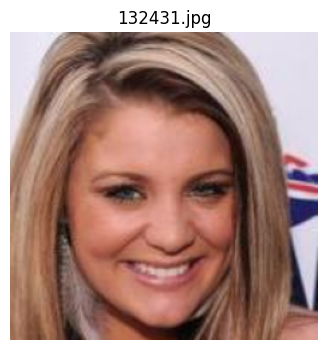

In [ ]:
# ─── 6. Visualize one random example ──────────────────────────────────────────
idx = np.random.randint(len(dataset))
print(f"Random index: {idx}")
img_t, lbl_t, fname = dataset[idx]

# undo normalization for display
img_disp = img_t.mul(0.5).add(0.5).clamp(0,1)
img_np   = img_disp.permute(1,2,0).cpu().numpy()
plt.figure(figsize=(4,4))
plt.imshow(img_np)
plt.axis('off')
plt.title(fname)
plt.show()

In [ ]:
# ─── 1) A true 4-level ontology ────────────────────────────────────────────────


'''
official_40 = {
    "5_o_Clock_Shadow","Arched_Eyebrows","Attractive","Bags_Under_Eyes","Bald","Bangs",
    "Big_Lips","Big_Nose","Black_Hair","Blond_Hair","Blurry","Brown_Hair","Bushy_Eyebrows",
    "Chubby","Double_Chin","Eyeglasses","Goatee","Gray_Hair","Heavy_Makeup","High_Cheekbones",
    "Male","Mouth_Slightly_Open","Mustache","Narrow_Eyes","No_Beard","Oval_Face","Pale_Skin",
    "Pointy_Nose","Receding_Hairline","Rosy_Cheeks","Sideburns","Smiling","Straight_Hair",
    "Wavy_Hair","Wearing_Earrings","Wearing_Hat","Wearing_Lipstick","Wearing_Necklace",
    "Wearing_Necktie","Young"
}
'''

ontology = {
    "Demographics": {
        "hasGender":        ["Male"],
        "hasAgeGroup":      ["Young"],
        "hasAttractiveness":["Attractive"],
    },
    "Hair": {
        "hasHairColor":     ["Black_Hair", "Blond_Hair", "Brown_Hair", "Gray_Hair"],
        "hasHairStyle":     ["Bald", "Bangs", "Straight_Hair",
                             "Wavy_Hair", "Receding_Hairline"],
    },
    "Facial Hair": {
        "hasFacialHair":    ["5_o_Clock_Shadow", "Mustache",
                             "Goatee", "No_Beard", "Sideburns"],
    },
    "Facial Features": {
        "hasFacialFeature": ["Arched_Eyebrows", "Bushy_Eyebrows",
                             "High_Cheekbones", "Narrow_Eyes",
                             "Big_Nose", "Big_Lips", "Pointy_Nose",
                             "Oval_Face", "Double_Chin", "Chubby"],
    },
    "Makeup/Accessories": {
        "wearsMakeup":      ["Heavy_Makeup", "Wearing_Lipstick"],
        "wearsAccessory":   ["Eyeglasses", "Wearing_Earrings",
                             "Wearing_Hat", "Wearing_Necklace",
                             "Wearing_Necktie"],
    },
    "Expression/Others": {
        "hasExpression":    ["Smiling", "Mouth_Slightly_Open"],
        "hasSkinFeature":   ["Bags_Under_Eyes", "Rosy_Cheeks", "Pale_Skin"],
        "hasImageQuality":  ["Blurry"],
    }
}

In [ ]:
df_attrs

,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,Blond_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
image_id,,,,,,,,,,,,,,,,,,,,,
000001.jpg,0,1,1,0,0,0,0,0,0,0,...,0,1,1,0,1,0,1,0,0,1
000002.jpg,0,0,0,1,0,0,0,1,0,0,...,0,1,0,0,0,0,0,0,0,1
000003.jpg,0,0,0,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,1
000004.jpg,0,0,1,0,0,0,0,0,0,0,...,0,0,1,0,1,0,1,1,0,1
000005.jpg,0,1,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202595.jpg,0,0,1,0,0,0,1,0,0,1,...,0,0,0,0,0,0,1,0,0,1
202596.jpg,0,0,0,0,0,1,1,0,0,1,...,0,1,1,0,0,0,0,0,0,1
202597.jpg,0,0,0,0,0,0,0,0,1,0,...,0,1,0,0,0,0,0,0,0,1


In [ ]:
df_attrs = pd.read_csv(attr_csv, index_col="image_id")

print("Columns = ", len(df_attrs.columns), "attributes:")
print(df_attrs.columns.tolist())   # should list exactly 40 names

# 1) Build a map from each attribute → its relation
relation_map = {
    attr: rel
    for category, subdict in ontology.items()
    for rel, attrs in subdict.items()
    for attr in attrs
}

# 2) Compare against the columns you loaded from CelebA
missing = set(df_attrs.columns) - set(relation_map.keys())
print("Missing in relation_map:", missing)   # Expect: set()

Columns =  40 attributes:
['5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive', 'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips', 'Big_Nose', 'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair', 'Bushy_Eyebrows', 'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee', 'Gray_Hair', 'Heavy_Makeup', 'High_Cheekbones', 'Male', 'Mouth_Slightly_Open', 'Mustache', 'Narrow_Eyes', 'No_Beard', 'Oval_Face', 'Pale_Skin', 'Pointy_Nose', 'Receding_Hairline', 'Rosy_Cheeks', 'Sideburns', 'Smiling', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Earrings', 'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Necklace', 'Wearing_Necktie', 'Young']
Missing in relation_map: set()


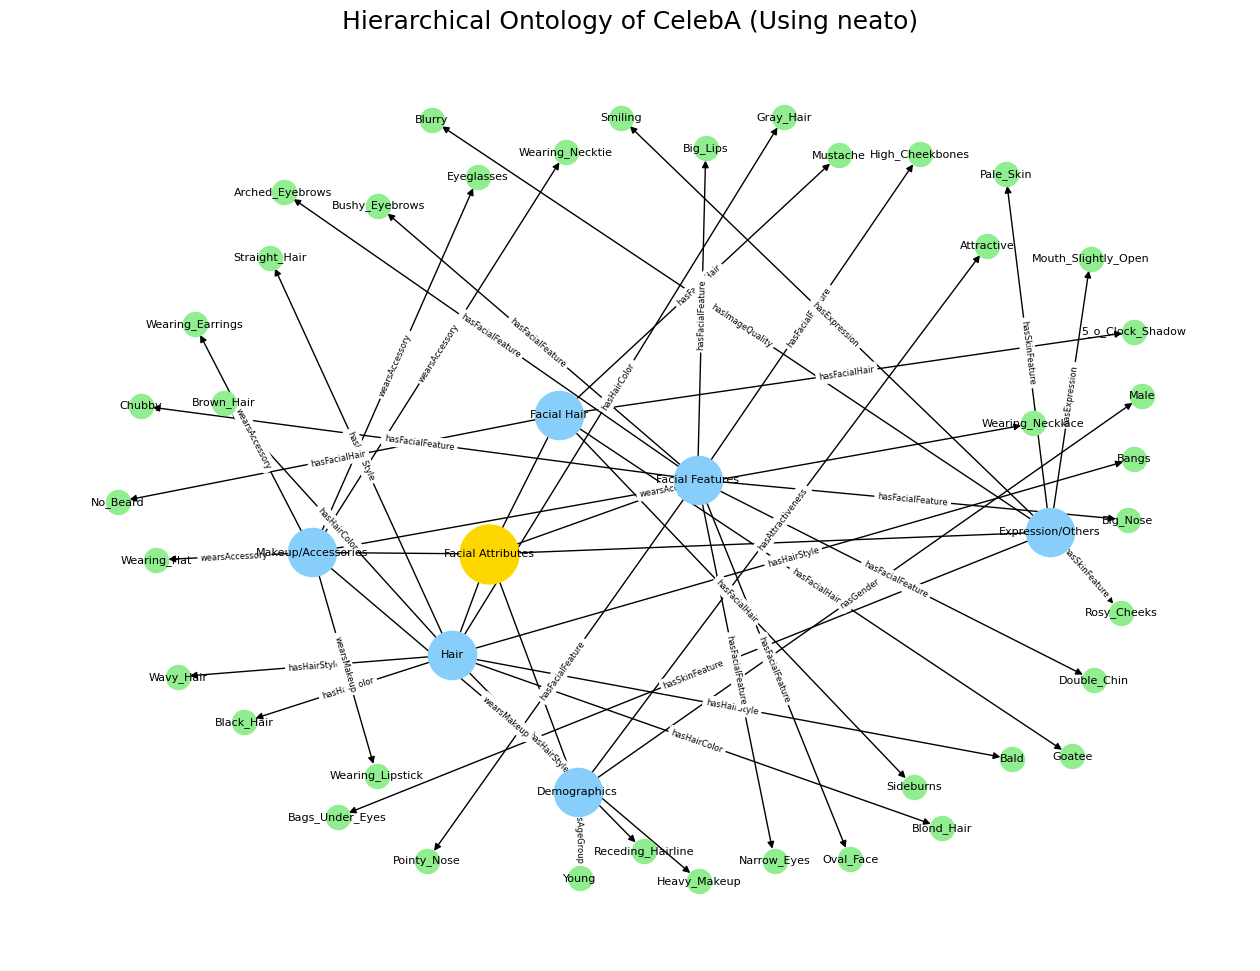

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

# (re-use the same 'ontology' dict and 'tree' construction as before …)

# Try to use Graphviz "neato" layout; if that fails, fall back to a looser spring layout
try:
    from networkx.drawing.nx_agraph import graphviz_layout
    # Change prog="dot" to prog="neato"
    pos = graphviz_layout(tree, prog="neato")
except ImportError:
    # Still a spring layout, but increase 'k' (repulsive force) to spread nodes out:
    pos = nx.spring_layout(tree, seed=420, k=1.6)  # ↑ increase k

plt.figure(figsize=(16, 12))

# Draw nodes exactly as before
level0 = ["Facial Attributes"]
level1 = list(ontology.keys())
level2 = [a for relations in ontology.values() for attrs in relations.values() for a in attrs]

nx.draw_networkx_nodes(tree, pos, nodelist=level0, node_color="#FFD700", node_size=1800)
nx.draw_networkx_nodes(tree, pos, nodelist=level1, node_color="#87CEFA", node_size=1200)
nx.draw_networkx_nodes(tree, pos, nodelist=level2, node_color="#90EE90", node_size=300)

nx.draw_networkx_edges(tree, pos, arrows=True, arrowstyle="-|>", arrowsize=10, width=1)
nx.draw_networkx_labels(tree, pos, font_size=8)

edge_labels = nx.get_edge_attributes(tree, 'label')
nx.draw_networkx_edge_labels(tree, pos, edge_labels=edge_labels, font_size=6)

plt.title("Hierarchical Ontology of CelebA (Using neato)", fontsize=18)
plt.axis("off")
plt.show()

In [ ]:
triples = []
for img_id, row in df_attrs.iterrows():
    img_entity = f"Image_{img_id.split('.')[0]}"
    for attr, val in row.items():
        if val == 1:
            rel = relation_map[attr]
            triples.append((img_entity, rel, attr))

print(f"Generated {len(triples)} image→attribute triples.")

Generated 1830201 image→attribute triples.


In [ ]:
!pip install pykeen

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.9/85.9 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 730.3/730.3 kB 20.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 38.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 125.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 90.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 60.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
from pathlib import Path
from pykeen.triples import TriplesFactory
from pykeen.pipeline import pipeline
import torch
triples_array = np.array(triples, dtype=np.object_)

INFO:pykeen.utils:Using opt_einsum


In [ ]:
# ─── B) Build a TriplesFactory ────────────────────────────────────────────────
tf = TriplesFactory.from_labeled_triples(
    triples_array,
    create_inverse_triples=False       # you can set True if you want inverse relations
)
print(f"Entities:  {tf.num_entities}")
print(f"Relations: {tf.num_relations}")
print(f"Triples:   {tf.num_triples:,}")


Entities:  202639
Relations: 12
Triples:   1,830,201


In [ ]:
# ─── C) Train a TransE model via the high-level pipeline ───────────────────────

In [ ]:
training, validation, testing = tf.split(
    ratios=[0.8, 0.1, 0.1],
    random_state=42,
)
num_epochs = 100

INFO:pykeen.triples.splitting:done splitting triples to groups of sizes [1261541, 183020, 183021]


In [ ]:
print(torch.cuda.is_available())

True


In [ ]:

from pykeen.pipeline import pipeline

result = pipeline(
    # your splits
    training=training,
    validation=validation,
    testing=testing,

    # model specs
    model='TransE',
    model_kwargs=dict(
        embedding_dim=50,
        scoring_fct_norm=1,
    ),

    # optimizer specs are top-level, not inside training_kwargs
    optimizer='Adam',
    optimizer_kwargs=dict(
        lr=1e-3, ### After 50/70 iters decrease -> 1e-4
    ),

    # only num_epochs, batch_size, checkpoint_name go here
    training_kwargs=dict(
        num_epochs=num_epochs,
        batch_size=512,
        checkpoint_name=None,
    ),

    device='cuda' if torch.cuda.is_available() else 'cpu',
    random_seed=42,
)


INFO:pykeen.pipeline.api:Using device: cuda
INFO:pykeen.nn.representation:Inferred unique=False for Embedding()
INFO:pykeen.nn.representation:Inferred unique=False for Embedding()


Training epochs on cuda:0:   0%|          | 0/100 [00:00<?, ?epoch/s]

Training batches on cuda:0:   0%|          | 0.00/2.86k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/2.86k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/2.86k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/2.86k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/2.86k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/2.86k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/2.86k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/2.86k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/2.86k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/2.86k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/2.86k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/2.86k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/2.86k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/2.86k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/2.86k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/2.86k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/2.86k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/2.86k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/2.86k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/2.86k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/2.86k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/2.86k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/2.86k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/2.86k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/2.86k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/2.86k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/2.86k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/2.86k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/2.86k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/2.86k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/2.86k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/2.86k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/2.86k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/2.86k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/2.86k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/2.86k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/2.86k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/2.86k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/2.86k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/2.86k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/2.86k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/2.86k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/2.86k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/2.86k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/2.86k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/2.86k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/2.86k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/2.86k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/2.86k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/2.86k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/2.86k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/2.86k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/2.86k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/2.86k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/2.86k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/2.86k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/2.86k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/2.86k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/2.86k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/2.86k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/2.86k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/2.86k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/2.86k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/2.86k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/2.86k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/2.86k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/2.86k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/2.86k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/2.86k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/2.86k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/2.86k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/2.86k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/2.86k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/2.86k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/2.86k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/2.86k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/2.86k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/2.86k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/2.86k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/2.86k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/2.86k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/2.86k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/2.86k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/2.86k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/2.86k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/2.86k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/2.86k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/2.86k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/2.86k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/2.86k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/2.86k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/2.86k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/2.86k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/2.86k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/2.86k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/2.86k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/2.86k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/2.86k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/2.86k [00:00<?, ?batch/s]

Training batches on cuda:0:   0%|          | 0.00/2.86k [00:00<?, ?batch/s]

Evaluating on cuda:0:   0%|          | 0.00/183k [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 442.94s seconds


In [ ]:
# ─── D) Save the trained model to disk ─────────────────────────────────────────
out_dir = Path("transE_celeba_3")
result.save_to_directory(out_dir)
print(f"Model and training artifacts saved to {out_dir}")

INFO:pykeen.triples.triples_factory:Stored TriplesFactory(num_entities=202639, num_relations=12, create_inverse_triples=False, num_triples=1464160) to file:///content/transE_celeba_3/training_triples
INFO:pykeen.pipeline.api:Saved to directory: /content/transE_celeba_3


Model and training artifacts saved to transE_celeba_3


In [ ]:
!zip -r transE_celeba_3.zip transE_celeba_3

# 2) Trigger a browser download
from google.colab import files
files.download("transE_celeba_3.zip")

  adding: transE_celeba_3/ (stored 0%)
  adding: transE_celeba_3/metadata.json (stored 0%)
  adding: transE_celeba_3/training_triples/ (stored 0%)
  adding: transE_celeba_3/training_triples/numeric_triples.tsv.gz (deflated 2%)
  adding: transE_celeba_3/training_triples/entity_to_id.tsv.gz (deflated 97%)
  adding: transE_celeba_3/training_triples/relation_to_id.tsv.gz (stored 0%)
  adding: transE_celeba_3/training_triples/base.pth (deflated 58%)
  adding: transE_celeba_3/trained_model.pkl (deflated 8%)
  adding: transE_celeba_3/results.json (deflated 78%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import os
print(os.listdir("transE_celeba_3"))


['metadata.json', 'training_triples', 'trained_model.pkl', 'results.json']


In [ ]:
### Note after around 50/60 iterations

In [ ]:
import os
from pathlib import Path

out_dir = Path("transE_celeba_3")
print("Top‐level contents:", os.listdir(out_dir))

tt_dir = out_dir / "training_triples"
print("Contents of training_triples/:", os.listdir(tt_dir))

Top‐level contents: ['metadata.json', 'training_triples', 'trained_model.pkl', 'results.json']
Contents of training_triples/: ['numeric_triples.tsv.gz', 'entity_to_id.tsv.gz', 'relation_to_id.tsv.gz', 'base.pth']


In [ ]:
### Load pipeline from drive

In [ ]:
# ─── A) Define paths ──────────────────────────────────────────────────────────
out_dir    = Path("transE_celeba_3")
tt_dir     = out_dir / "training_triples"
model_path = out_dir / "trained_model.pkl"
ent_map_fp = tt_dir  / "entity_to_id.tsv.gz"
rel_map_fp = tt_dir  / "relation_to_id.tsv.gz"
triples_fp = tt_dir  / "numeric_triples.tsv.gz"

In [ ]:
import pandas as pd
from pathlib import Path

ent_map_fp = Path("transE_celeba_3") / "training_triples" / "entity_to_id.tsv.gz"
rel_map_fp = Path("transE_celeba_3") / "training_triples" / "relation_to_id.tsv.gz"

# ─── 1) Load entity_to_id.tsv.gz, letting pandas treat the first row as header ─
df_ent = pd.read_csv(
    ent_map_fp,
    sep="\t",
    compression="gzip",
    header=0,        # “id” and “label” are on the first line
)

# Now df_ent.columns == ["id", "label"], with df_ent["id"] = [0,1,2,…], df_ent["label"] = ["5_o_Clock_Shadow", …]
# Build a dict { string_label → int_ID }
entity_to_id = dict(zip(df_ent["label"], df_ent["id"].astype(int)))

# ─── 2) Likewise for relation_to_id.tsv.gz ─────────────────────────────────
df_rel = pd.read_csv(
    rel_map_fp,
    sep="\t",
    compression="gzip",
    header=0,        # “id” and “label” are on the first line
)

relation_to_id = dict(zip(df_rel["label"], df_rel["id"].astype(int)))

# ─── 3) Verify that the keys are now your actual attribute strings ────────────
print("Total # entities   :", len(entity_to_id))
print("Total # relations  :", len(relation_to_id))

print("\nSome example entity‐strings:")
for i, ent in enumerate(entity_to_id.keys()):
    print(f"  {i:>4d}. {ent}")
    if i >= 9:
        break

print("\nAll relation‐strings:")
for i, rel in enumerate(relation_to_id.keys()):
    print(f"  {i:>2d}. {rel}")

Total # entities   : 202639
Total # relations  : 12

Some example entity‐strings:
     0. 5_o_Clock_Shadow
     1. Arched_Eyebrows
     2. Attractive
     3. Bags_Under_Eyes
     4. Bald
     5. Bangs
     6. Big_Lips
     7. Big_Nose
     8. Black_Hair
     9. Blond_Hair

All relation‐strings:
   0. hasAgeGroup
   1. hasAttractiveness
   2. hasExpression
   3. hasFacialFeature
   4. hasFacialHair
   5. hasGender
   6. hasHairColor
   7. hasHairStyle
   8. hasImageQuality
   9. hasSkinFeature
  10. wearsAccessory
  11. wearsMakeup


In [ ]:
# Example: lookup “Male” and “hasAgeGroup”
head_str = "Male"
rel_str  = "hasAgeGroup"

head_id = entity_to_id[head_str]
rel_id  = relation_to_id[rel_str]

print(f"head_id for 'Male'       = {head_id}")
print(f"rel_id  for 'hasAgeGroup' = {rel_id}")

head_id for 'Male'       = 202619
rel_id  for 'hasAgeGroup' = 0


In [ ]:
# ─── B) Load your trained TransE model ───────────────────────────────────────
import torch
model = torch.load(model_path, map_location="cpu", weights_only=False)
model.eval()
num_entities  = model.num_entities
num_relations = model.num_relations

print("Model expects:")
print(f"  • num_entities  = {num_entities}")
print(f"  • num_relations = {num_relations}")

Model expects:
  • num_entities  = 202639
  • num_relations = 12


In [ ]:
# ─── C) Read numeric_triples.tsv.gz into a torch.LongTensor ─────────────────
# Skip the header row ("head<tab>relation<tab>tail") so it isn’t parsed as data:
df_num = pd.read_csv(
    triples_fp,
    sep="\t",
    header=None,
    skiprows=1,
    compression="gzip",
    names=["head_id", "relation_id", "tail_id"],
)
# Convert to a pure int64 NumPy array, then to a LongTensor
numeric_np     = df_num[["head_id", "relation_id", "tail_id"]].to_numpy(dtype=np.int64)
triples_tensor = torch.from_numpy(numeric_np).long()  # shape = (N, 3)

print(f"→ Loaded numeric triples: shape = {triples_tensor.shape}")

→ Loaded numeric triples: shape = torch.Size([1464160, 3])


In [ ]:
# ─── D) Build a “string‐ID” array so PyKEEN can use from_labeled_triples ─────
# Convert each integer to its string form:
string_np = numeric_np.astype(str)  # dtype becomes something like '<U10'
print("→ string_np.dtype =", string_np.dtype, "shape =", string_np.shape)

# Build maps { "0": 0, "1": 1, …, f"{num_entities-1}": num_entities-1 }
entity_to_id_str = { str(i): i for i in range(num_entities) }
relation_to_id_str = { str(r): r for r in range(num_relations) }

# Now call from_labeled_triples with string_np and those maps.
tf_num = TriplesFactory.from_labeled_triples(
    string_np,
    entity_to_id=entity_to_id_str,
    relation_to_id=relation_to_id_str,
    create_inverse_triples=False,  # same as during training
)

print("✔ Reconstructed TriplesFactory from stringified‐IDs:")
print(f"  • #Entities      = {tf_num.num_entities}")   # should = num_entities
print(f"  • #Relations     = {tf_num.num_relations}")  # should = num_relations
print(f"  • #Total triples = {tf_num.num_triples}")    # should = numeric_np.shape[0]

→ string_np.dtype = <U21 shape = (1464160, 3)
✔ Reconstructed TriplesFactory from stringified‐IDs:
  • #Entities      = 202639
  • #Relations     = 12
  • #Total triples = 1464160


In [ ]:
# ─── E) Reload the original mappings: entity_to_id.tsv.gz and relation_to_id.tsv.gz ─
# Each file’s first line is a header: “id<TAB>label”. Below that, “<int_id><TAB><string_label>”.

df_ent = pd.read_csv(
    ent_map_fp,
    sep="\t",
    compression="gzip",
    header=0,        # first row is “id” and “label”
    names=["id", "label"],
    dtype={"id": int, "label": str},
)
# Build dict { "Masculine": 0, "Young": 2, … } where 0,2,… match the KG’s integer IDs.
entity_to_id = dict(zip(df_ent["label"], df_ent["id"]))

df_rel = pd.read_csv(
    rel_map_fp,
    sep="\t",
    compression="gzip",
    header=0,        # first row is “id” and “label”
    names=["id", "label"],
    dtype={"id": int, "label": str},
)
relation_to_id = dict(zip(df_rel["label"], df_rel["id"]))

print(f"Total # entities   : {len(entity_to_id)}")
print(f"Total # relations  : {len(relation_to_id)}")

Total # entities   : 202639
Total # relations  : 12


In [ ]:
for i, ent in enumerate(entity_to_id.keys()):
    print(f"  {i:>4d}. {ent}")
    if i >= 9:
        break

print("\nAll relation‐strings:")
for i, rel in enumerate(relation_to_id.keys()):
    print(f"  {i:>2d}. {rel}")

# Build reverse maps { int_ID → string_label }
id_to_entity   = {v: k for k, v in entity_to_id.items()}
id_to_relation = {v: k for k, v in relation_to_id.items()}

     0. 5_o_Clock_Shadow
     1. Arched_Eyebrows
     2. Attractive
     3. Bags_Under_Eyes
     4. Bald
     5. Bangs
     6. Big_Lips
     7. Big_Nose
     8. Black_Hair
     9. Blond_Hair

All relation‐strings:
   0. hasAgeGroup
   1. hasAttractiveness
   2. hasExpression
   3. hasFacialFeature
   4. hasFacialHair
   5. hasGender
   6. hasHairColor
   7. hasHairStyle
   8. hasImageQuality
   9. hasSkinFeature
  10. wearsAccessory
  11. wearsMakeup


In [ ]:
# ─── F) Define helper functions for link‐prediction ──────────────────────────
def top_k_tails_from_ids(model, head_id: int, rel_id: int, k: int = 5):
    """
    Given a trained TransE `model` and integer IDs `head_id`, `rel_id`,
    score every possible tail in [0 .. num_entities - 1], and return the
    top‐k scoring tail IDs and their scores.
    """
    n_ent = model.num_entities
    device = next(model.parameters()).device

    heads = torch.full((n_ent,), head_id, dtype=torch.long, device=device)
    rels  = torch.full((n_ent,), rel_id,   dtype=torch.long, device=device)
    tails = torch.arange(n_ent,      dtype=torch.long, device=device)

    batch = torch.stack([heads, rels, tails], dim=1)  # shape = (n_ent, 3)
    with torch.no_grad():
        scores = model.score_hrt(batch)               # shape = (n_ent,)

    topk = torch.topk(scores, k=k, largest=True)
    topk_ids    = topk.indices.cpu().tolist()
    topk_scores = topk.values.cpu().tolist()

    return list(zip(topk_ids, topk_scores))


def top_k_heads_from_ids(model, rel_id: int, tail_id: int, k: int = 5):
    """
    Given `rel_id` and `tail_id`, enumerate all head candidates 0..num_entities-1.
    Return top‐k head IDs and scores.
    """
    n_ent = model.num_entities
    device = next(model.parameters()).device

    heads = torch.arange(n_ent,      dtype=torch.long, device=device)
    rels  = torch.full((n_ent,), rel_id,  dtype=torch.long, device=device)
    tails = torch.full((n_ent,), tail_id, dtype=torch.long, device=device)

    batch = torch.stack([heads, rels, tails], dim=1)
    with torch.no_grad():
        scores = model.score_hrt(batch)

    topk = torch.topk(scores, k=k, largest=True)
    topk_ids    = topk.indices.cpu().tolist()
    topk_scores = topk.values.cpu().tolist()

    return list(zip(topk_ids, topk_scores))


def top_k_rels_from_ids(model, head_id: int, tail_id: int, k: int = 5):
    """
    Given `head_id` and `tail_id`, enumerate all relation candidates 0..num_relations-1.
    Return top‐k relation IDs and scores.
    """
    n_rel = model.num_relations
    device = next(model.parameters()).device

    heads = torch.full((n_rel,), head_id, dtype=torch.long, device=device)
    rels  = torch.arange(n_rel,     dtype=torch.long, device=device)
    tails = torch.full((n_rel,), tail_id, dtype=torch.long, device=device)

    batch = torch.stack([heads, rels, tails], dim=1)
    with torch.no_grad():
        scores = model.score_hrt(batch)

    topk = torch.topk(scores, k=k, largest=True)
    topk_ids    = topk.indices.cpu().tolist()
    topk_scores = topk.values.cpu().tolist()

    return list(zip(topk_ids, topk_scores))

In [ ]:
print("Model.num_entities  =", model.num_entities)
print("TF.num_entities     =", tf_num.num_entities)
print("Model.num_relations =", model.num_relations)
print("TF.num_relations    =", tf_num.num_relations)

Model.num_entities  = 202639
TF.num_entities     = 202639
Model.num_relations = 12
TF.num_relations    = 12


In [ ]:
# ─── G) Example usage ─────────────────────────────────────────────────────────
# 1) Pick a valid head_str and rel_str from your mappings:
head_str = "Male"         # any key in `entity_to_id`
rel_str  = "hasAgeGroup"  # any key in `relation_to_id`

# 2) Convert to integer IDs:
head_id = entity_to_id[head_str]
rel_id  = relation_to_id[rel_str]
print(f"\nQuery: (head={head_str!r} [ID={head_id}], rel={rel_str!r} [ID={rel_id}])")

# 3) Tail‐prediction:
top5_tails = top_k_tails_from_ids(model, head_id, rel_id, k=5)
print(f"\nTop 5 tail candidates for ('{head_str}', '{rel_str}', ?):")
for rank, (tid, score) in enumerate(top5_tails, start=1):
    tail_str = id_to_entity[tid]
    print(f"  {rank:>2}. {tail_str:<20s} (ID={tid:>6d}, score={score:.4f})")

# 4) Head‐prediction:
#    For ( ?, hasAgeGroup, "Young" ):
tail_str = "Young"
tail_id  = entity_to_id[tail_str]
top5_heads = top_k_heads_from_ids(model, rel_id, tail_id, k=5)
print(f"\nTop 5 head candidates for (?, '{rel_str}', '{tail_str}'):")
for rank, (hid, score) in enumerate(top5_heads, start=1):
    head_out = id_to_entity[hid]
    print(f"  {rank:>2}. {head_out:<20s} (ID={hid:>6d}, score={score:.4f})")

# 5) Relation‐prediction:
#    For ("Male", ?, "Young"):
top5_rels = top_k_rels_from_ids(model, head_id, tail_id, k=5)
print(f"\nTop 5 relation candidates for ('{head_str}', ?, '{tail_str}'):")
for rank, (rid, score) in enumerate(top5_rels, start=1):
    rel_out = id_to_relation[rid]
    print(f"  {rank:>2}. {rel_out:<20s} (ID={rid:>6d}, score={score:.4f})")


Query: (head='Male' [ID=202619], rel='hasAgeGroup' [ID=0])


RuntimeError: selected index k out of range

In [ ]:
import torch
import numpy as np

# 1) Grab the representation module
rep = result.model.entity_representations[0]

# 2) Make a tensor of all entity IDs
num_entities = tf.num_entities
all_ids = torch.arange(num_entities, dtype=torch.long)

# 3) Call the module to get all embeddings at once
#    Shape will be [num_entities, embedding_dim]
with torch.no_grad():
    weights = rep(all_ids).cpu().numpy()

print("weights.shape:", weights.shape)  # e.g. (202639, 50)

# 4) Build your 40×50 attribute‐only matrix
ent2id     = tf.entity_to_id
attr_names = list(df_attrs.columns)    # your 40 attribute names
attr_embeddings = np.vstack([weights[ent2id[a]] for a in attr_names])
print("attr_embeddings.shape:", attr_embeddings.shape)  # (40, 50)


weights.shape: (202639, 50)
attr_embeddings.shape: (40, 50)


In [ ]:
##  Build your per–image vectors

In [ ]:
import torch
from torch.utils.data import TensorDataset, DataLoader

# attr_embeddings: NumPy array shape (40, 50)
attr_emb_t = torch.from_numpy(attr_embeddings)       # [40, 50]

# Build a list of per–image vectors
vectors = []
for img_name, row in df_attrs.iterrows():
    # row is series of 0/1 labels for the 40 attrs
    labels = torch.tensor(row.values, dtype=torch.float32)  # [40]
    # multiply each attr embedding by its label and flatten
    vec = (labels.unsqueeze(1) * attr_emb_t).view(-1)       # [40*50]
    vectors.append(vec)

# Stack into one big tensor [N_images, 2000]
X = torch.stack(vectors)
print("Per‐image matrix X:", X.shape)
# Wrap as a DataLoader for training
dataset_ae = TensorDataset(X, X)
loader = DataLoader(dataset_ae, batch_size=256, shuffle=True)


Per‐image matrix X: torch.Size([202599, 2000])
